# Web Scraping

In [1]:
import os
import re
import time
import requests
import pandas as pd

from bs4 import BeautifulSoup
from pprint import pprint
from selenium import webdriver

There is no silver bullet to getting info from the internet.
The coding requirements in these notes start easy and will gradually become more demanding. We will cover the following web scraping techniques:

1. Pandas
2. APIs
3. Scraping static webpages with BeautifulSoup
4. Scraping dynamic wepages with Selenium

## Pandas

The Pandas library has a very useful webscraping command: `read_html`. The `read_html` command works for webpages that contain tables that are particularly well behaved. Let's see an example: https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)

At first glance, it seems that there are three tables in this Wikipedia page:
1. data from the IMF
2. data from the World Bank
3. data from the UN

Let's see which tables pandas recognizes.

In [2]:
# Scrape all tables from Wikipedia page
url = 'https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)'
df_list = pd.read_html(url)

# Check number of tables on the page
print(len(df_list))

7


Apparently Pandas has found 10 tables in this webpage. Let's see what is their content.

In [3]:
# Check headers of each table
for df in df_list: print(df.shape)

(1, 1)
(1, 3)
(216, 9)
(9, 2)
(7, 2)
(13, 2)
(2, 2)


It seems that pandas has found many more tables that we could see. The ones that are of interest to us are probably the 3rd, 4th and 5th. But that are the others? Let's look at the them.

In [4]:
# Check first
df_list[0].head()

,0
0,Largest economies by nominal GDP in 2021[1]


In [5]:
# Check second
df_list[1].head()

,0,1,2
0,.mw-parser-output .legend{page-break-inside:av...,$750 billion – $1 trillion $500–50 billion $25...,$50–100 billion $25–50 billion $5–25 billion <...


Apparently, the first two are simply picture captions.

In [6]:
# Check third
df_list[2].head()

Country/Territory         Subregion    Region      IMF[1]             \
  Country/Territory         Subregion    Region    Estimate       Year   
0     United States  Northern America  Americas  22939580.0       2021   
1             China      Eastern Asia      Asia  16862979.0  [n 2]2021   
2             Japan      Eastern Asia      Asia   5103110.0       2021   
3           Germany    Western Europe    Europe   4230172.0       2021   
4    United Kingdom    Western Europe    Europe   3108416.0       2021   

  United Nations[12]            World Bank[13][14]        
            Estimate       Year           Estimate  Year  
0         20893746.0       2020         20936600.0  2020  
1         14722801.0  [n 3]2020         14722731.0  2020  
2          5057759.0       2020          4975415.0  2020  
3          3846414.0       2020          3806060.0  2020  
4          2764198.0       2020          2707744.0  2020

This is clearly what we were looking for. A part from the footnotes, the table is already clean and organized.

If we knew the name of the table, we could directly retrieve it. However, we will see more about it in the next lecture.

## Specific Libraries

Sometimes, there are libraries that are already written down to do the scraping for you. Each one is tailored for a specific website and they are usually userwritten and prone to bugs and errors. However, they are often efficient and save you the time to worry about getting around some website-specific issues.

One example is the `pytrends` library for scraping Google Trends. Let's first install it

```python
pip3 install pytrends
```

Let's see how it works. Imagine we want to do the following search:
- words "python", "matlab", "stata"
- the the second half of in 2019
- daily
- in the US

We can get more details on how pytrends works [here](https://github.com/GeneralMills/pytrends#historical-hourly-interest). The important thing to know is that if you query a time period of more than 200 days, Google will give you weekly results, instead of daily.

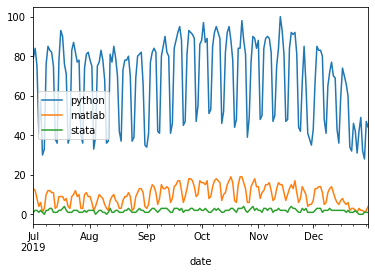

In [7]:
# Pytrends search
from pytrends.request import TrendReq

# Set parameters
words = ['python', 'matlab', 'stata']
timeframe = '2019-07-01 2019-12-31'
country = 'US'

# Get data
pytrend = TrendReq()
pytrend.build_payload(kw_list=words, timeframe=timeframe, geo=country)
df_trends = pytrend.interest_over_time()

# Plot
trends_plot = df_trends.plot.line()

Apparently people don't code during the weekend....

## APIs

From Wikipedia 

> An application programming interface (API) is an interface or communication protocol between different parts of a computer program intended to simplify the implementation and maintenance of software.

In practice, it means that the are some webpages that are structured not to be user-readable but to be computer-readable. Let's see one example.

Google provides many APIs for its services. However, they now all need identification, which means that you have to log in into your Google account and request an API key from there. This allows Google to monitor your behavior since the number of API requests is limited and beyond a certain treshold, one need to pay (a lot).

There are however some free APIs. One 

Let's have a look at one of these: zippopotam. Zippopotam lets you retrieve location information from a zip code in the US. Other countries are supported as well. 

In [8]:
# Let's search the department locatiton
import requests

zipcode = '90210'
url = 'https://api.zippopotam.us/us/'+zipcode

response = requests.get(url)
data = response.json()
data

{'post code': '90210',
 'country': 'United States',
 'country abbreviation': 'US',
 'places': [{'place name': 'Beverly Hills',
   'longitude': '-118.4065',
   'state': 'California',
   'state abbreviation': 'CA',
   'latitude': '34.0901'}]}

Data is in JSON (JavaScript Object Notation) format which is basically a nested dictionary-list format. Indeed, we see that in our case, data is a dictionary where the last elements is a list with one element - another dictionary.

In [9]:
# Check type of value
for d in data.values():
    print(type(d))
    
# Check list length
print(len(data['places']))

# Check type of content of list
print(type(data['places'][0]))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'list'>
1
<class 'dict'>


The part that could be interesting to us is contained in the `places` category. We can easily extract it and transform it into a dataframe.

In [10]:
# Add zipcode to data
data['places'][0]['zipcode'] = zipcode

# Export data
df = pd.DataFrame(data['places'])
df

,place name,longitude,state,state abbreviation,latitude,zipcode
0,Beverly Hills,-118.4065,California,CA,34.0901,90210


## Static Webscraping

We have so far used pre-made tools in order to do web-scraping. When the website contains the data in a nice table or an API is available, we do not need to worry much and we can directly retrieve the data. However, most of web scraping is much more complicated. Data is often the product of webscraping and is not readily available. Moreover, sometimes webscraping knowledge can supplement the need to pay for an API. 

### HTTP

What happens when you open a page on the internet? In short, your web browser is sending a request to the website that, in turn, sends back a reply/response. The exchange of messages is complex but its core involves a HyperText Transfer Protocol (HTTP) request message to a web server, followed by a HTTP response (or reply). All static webscraping is build on HTTP so let's have a closer look.

An HTTP message essentially has 4 components:
1. A request line
2. A number of request headers
3. An empty line
4. An optional message

*Example*

A request message could be 
```
GET /hello.htm HTTP/1.1
```

The response would be
```
HTTP/1.1 200 OK
Date: Sun, 10 Oct 2010 23:26:07 GMT
Server: Apache/2.2.8 (Ubuntu) mod_ssl/2.2.8 OpenSSL/0.9.8g
Last-Modified: Sun, 26 Sep 2010 22:04:35 GMT
ETag: "45b6-834-49130cc1182c0"
Accept-Ranges: bytes
Content-Length: 12
Connection: close
Content-Type: text/html

<html>
   <body>
   
      <h1>Hello, World!</h1>
   
   </body>
</html>
```
So, in this case the parts are:
1. The **request line**
```
HTTP/1.1 200 OK
```
2. The **request headers**
```
Date: Sun, 10 Oct 2010 23:26:07 GMT
Server: Apache/2.2.8 (Ubuntu) mod_ssl/2.2.8 OpenSSL/0.9.8g
Last-Modified: Sun, 26 Sep 2010 22:04:35 GMT
ETag: "45b6-834-49130cc1182c0"
Accept-Ranges: bytes
Content-Length: 12
Connection: close
Content-Type: text/html
```
3. The **empty line**
4. The **optional message**
```
<html>
   <body>
   
      <h1>Hello, World!</h1>
   
   </body>
</html>
```

We are interested in the optional message, which is essentially the content of the page we want to scrape. The content is usually written in HTML which is not a proper programming language but rather a *typesetting language* since it is the language underlying web pages and is usually generated from other programming languages. 

### Requests

There are many different packages in python to send requests to a web page and read its response. The most user-friendly is the `requests` package. You can find plenty of useful information on the `requests` library on its website: https://requests.readthedocs.io/en/master/.

We are now going to have a look at a simple example: http://pythonscraping.com/pages/page1.html.

In [11]:
# Request a simple web page
url1 = 'http://pythonscraping.com/pages/page1.html'
response = requests.get(url1)
print(response)

<Response [200]>


We are (hopefully) getting a `<Response [200]>` message. In short, what we got is the status code of the request we sent to the website. The status code is a 3-digit code and essentially there are two broad categories of status codes:
- 2XX: success
- 4XX, 5XX: failure

It can be useful to know this codes as they are a fast way to check whether your request has failed or not. When webscraping the most common reasons you get an error are
1. The link does not exist: wither the link is old/expired or you misspelled it and hence there is no page to request
2. You have been "caught". This is pretty common when webscraping and happens every time you are too aggressive with your scraping. How much "aggressive" is "too agrressive" depends on the website. Usually big tech websites are particularly hard to scrape and anything that is "faster than human" gets blocked. Sometimes also slow but persistent requests get blocked as well.

We have now analyzed the response status but, what is actually the response content? Let's inspect the response object more in detail.

In [12]:
# Print response attributes
dir(response)

['__attrs__',
 '__bool__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_content',
 '_content_consumed',
 '_next',
 'apparent_encoding',
 'close',
 'connection',
 'content',
 'cookies',
 'elapsed',
 'encoding',
 'headers',
 'history',
 'is_permanent_redirect',
 'is_redirect',
 'iter_content',
 'iter_lines',
 'json',
 'links',
 'next',
 'ok',
 'raise_for_status',
 'raw',
 'reason',
 'request',
 'status_code',
 'text',
 'url']

We are actually interested in the text of the response.

In [13]:
# Print response content
response.text

'<html>\n<head>\n<title>A Useful Page</title>\n</head>\n<body>\n<h1>An Interesting Title</h1>\n<div>\nLorem ipsum dolor sit amet, consectetur adipisicing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.\n</div>\n</body>\n</html>\n'

This is the whole content of the table. There is a large chunk of text and other parts which look more obscure. In order to understand the structure of the page, we need to have a closer look at the language in which the webpage is written: HTML. We will do it in the next section. 

However, let's first analyze the other relevant components of the response. We have already had a look at the status. Let's inspect the headers.

In [14]:
# Print response headers
response.headers

{'Server': 'nginx', 'Date': 'Thu, 10 Feb 2022 11:11:41 GMT', 'Content-Type': 'text/html', 'Content-Length': '361', 'Connection': 'keep-alive', 'X-Accel-Version': '0.01', 'Last-Modified': 'Sat, 09 Jun 2018 19:15:58 GMT', 'ETag': '"234-56e3a58a63780-gzip"', 'Accept-Ranges': 'bytes', 'Vary': 'Accept-Encoding', 'Content-Encoding': 'gzip', 'X-Powered-By': 'PleskLin'}

From the headers we can see
- the present date
- the name of the server hosting the page
- the last time the page was modified
- other stuff

Let's now look at the headers of our request.

In [15]:
# Request headers
def check_headers(r):
    test_headers = dict(zip(r.request.headers.keys(), r.request.headers.values()))
    pprint(test_headers)
    
check_headers(response)

{'Accept': '*/*',
 'Accept-Encoding': 'gzip, deflate, br',
 'Connection': 'keep-alive',
 'User-Agent': 'python-requests/2.27.1'}


The headers of our request are pretty minimal. In order to see what normal headers look like, go to https://www.whatismybrowser.com/developers/what-http-headers-is-my-browser-sending

Normal headers look something like:
```
{'Accept': 'text/html,application/xhtml+xml,application/xml;q = 0.9, image / '
           'webp, * / *;q = 0.8',
 'Accept-Encoding': 'gzip, deflate, br',
 'Accept-Language': 'en-US,en;q=0.9,it-IT;q=0.8,it;q=0.7,de-DE;q=0.6,de;q=0.5',
 'Connection': 'keep-alive',
 'Host': 'www.whatismybrowser.com',
 'Referer': 'http://localhost:8888/',
 'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) '
               'AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.88 '
               'Safari/537.36'}
```   

The most important difference is that the `requests` model default *User-Agent* is `python-requests/2.22.0` which means that we are walking around the web with a big **WARNING: web scrapers** sign. This is the simplest way to get caught and blocked by a website. Luckily, we can easily change our headers in order to be more subtle.

In [16]:
# Change headers
headers = {"User-Agent": "Mozilla/5.0",
               "Accept": "webp, * / *;q = 0.8",
               "Accept-Language": "en-US,en;q=0.9",
               "Accept-Encoding": "br, gzip, deflate",
               "Referer": "https://www.google.ch/"}

# Test if change worked
response = requests.get(url1, headers=headers)
check_headers(response)

{'Accept': 'webp, * / *;q = 0.8',
 'Accept-Encoding': 'br, gzip, deflate',
 'Accept-Language': 'en-US,en;q=0.9',
 'Connection': 'keep-alive',
 'Referer': 'https://www.google.ch/',
 'User-Agent': 'Mozilla/5.0'}


Nice! Now we are a little more stealthy.

You might now be asking yourself what are the ethical limits of webscraping. Information on the internet is public but scraping a website imposes a workload on the website's server. If the website is not protected against aggressive scrapers (most websites are), your activity could significantly slower the website or even crash it.

Usually websites include their policies for scraping in a text file named `robots.txt`.

Let's have a look at the `robots.txt` file of http://pythonscraping.com/. 

In [17]:
# Read robots.txt
response = requests.get('http://pythonscraping.com/robots.txt')
print(response.text)

#
# robots.txt
#
# This file is to prevent the crawling and indexing of certain parts
# of your site by web crawlers and spiders run by sites like Yahoo!
# and Google. By telling these "robots" where not to go on your site,
# you save bandwidth and server resources.
#
# This file will be ignored unless it is at the root of your host:
# Used:    http://example.com/robots.txt
# Ignored: http://example.com/site/robots.txt
#
# For more information about the robots.txt standard, see:
# http://www.robotstxt.org/robotstxt.html
#
# For syntax checking, see:
# http://www.frobee.com/robots-txt-check

User-agent: *
Crawl-delay: 10
# Directories
Disallow: /includes/
Disallow: /misc/
Disallow: /modules/
Disallow: /profiles/
Disallow: /scripts/
Disallow: /themes/
# Files
Disallow: /CHANGELOG.txt
Disallow: /cron.php
Disallow: /INSTALL.mysql.txt
Disallow: /INSTALL.pgsql.txt
Disallow: /INSTALL.sqlite.txt
Disallow: /install.php
Disallow: /INSTALL.txt
Disallow: /LICENSE.txt
Disallow: /MAINTAINERS.txt
Dis

As we can see, this `robots.txt` file mostly deals with crawlers, i.e. scripts that are designed to recover the structure of a website by exploring it. Crawlers are mostly used by browsers that want to index websites.

Now we have explored most of the issues around HTTP requests. We can now proceed to what we are interested in: the content of the web page. In order to do that, we need to know the language in which wabpages are written: HTML.

###  HTML

Hypertext Markup Language (HTML) is the standard markup language for documents designed to be displayed in a web browser. Web browsers receive HTML documents from a web server or from local storage and render the documents into multimedia web pages. HTML describes the structure of a web page semantically and originally included cues for the appearance of the document.

HTML elements are delineated by tags, written using angle brackets. 

#### Tags

Tags are the cues that HTML uses to surround content and provide information about its nature. There is a very large amount of tags but some of the most common are:
- `<head>` and `<body>` for head and body of the page
- `<p>` for paragraphs
- `<br>` for line breaks
- `<table>` for tables. These are the ones that `pandas` reads. However, we have seen that not all elements that look like tables are actually `<table>` and viceversa. Table elements are tagged as `<th>` (table header), `<tr>` (table row) and `<td>` (table data: a cell)
- `<img>` for images
- `<h1>` to `<h6>` for headers (titles and subtitles)
- `<div>` dor divisions, i.e. for grouping elements
- `<a>` for hyperlinks
- `<ul>` and `<ol>` for unordered and ordered lists where list elements are tagged as `<li>`

Let's have a look at the previous page

In [18]:
# Inspect HTML
response.text

'#\n# robots.txt\n#\n# This file is to prevent the crawling and indexing of certain parts\n# of your site by web crawlers and spiders run by sites like Yahoo!\n# and Google. By telling these "robots" where not to go on your site,\n# you save bandwidth and server resources.\n#\n# This file will be ignored unless it is at the root of your host:\n# Used:    http://example.com/robots.txt\n# Ignored: http://example.com/site/robots.txt\n#\n# For more information about the robots.txt standard, see:\n# http://www.robotstxt.org/robotstxt.html\n#\n# For syntax checking, see:\n# http://www.frobee.com/robots-txt-check\n\nUser-agent: *\nCrawl-delay: 10\n# Directories\nDisallow: /includes/\nDisallow: /misc/\nDisallow: /modules/\nDisallow: /profiles/\nDisallow: /scripts/\nDisallow: /themes/\n# Files\nDisallow: /CHANGELOG.txt\nDisallow: /cron.php\nDisallow: /INSTALL.mysql.txt\nDisallow: /INSTALL.pgsql.txt\nDisallow: /INSTALL.sqlite.txt\nDisallow: /install.php\nDisallow: /INSTALL.txt\nDisallow: /LICENS

The response looks a little bit messy and not really readable. 

`BeautifulSoup` is a python library that renders http responses in a user friendly format and helps recovering elements from tags and attributes.

```
pip3 install bs4
```

Let's have a look.

In [19]:
# Make response readable
soup = BeautifulSoup(response.text, 'lxml')
print(soup)

<html><body><p>#
# robots.txt
#
# This file is to prevent the crawling and indexing of certain parts
# of your site by web crawlers and spiders run by sites like Yahoo!
# and Google. By telling these "robots" where not to go on your site,
# you save bandwidth and server resources.
#
# This file will be ignored unless it is at the root of your host:
# Used:    http://example.com/robots.txt
# Ignored: http://example.com/site/robots.txt
#
# For more information about the robots.txt standard, see:
# http://www.robotstxt.org/robotstxt.html
#
# For syntax checking, see:
# http://www.frobee.com/robots-txt-check

User-agent: *
Crawl-delay: 10
# Directories
Disallow: /includes/
Disallow: /misc/
Disallow: /modules/
Disallow: /profiles/
Disallow: /scripts/
Disallow: /themes/
# Files
Disallow: /CHANGELOG.txt
Disallow: /cron.php
Disallow: /INSTALL.mysql.txt
Disallow: /INSTALL.pgsql.txt
Disallow: /INSTALL.sqlite.txt
Disallow: /install.php
Disallow: /INSTALL.txt
Disallow: /LICENSE.txt
Disallow: /MAIN

First of all, what is the `html5lib` option? It's the parser. In short, there are often small mistakes/variations in HTML and each parser interprets it differently. In principles, the latest HTML standard is HTML5, therefore the `html5lib` parser should be the most "correct" parser. It might happen that the same code does not work for another person if you use a different parser.

This is much better but it can be improved. 

In [20]:
# Prettify response
print(soup.prettify())

<html>
 <body>
  <p>
   #
# robots.txt
#
# This file is to prevent the crawling and indexing of certain parts
# of your site by web crawlers and spiders run by sites like Yahoo!
# and Google. By telling these "robots" where not to go on your site,
# you save bandwidth and server resources.
#
# This file will be ignored unless it is at the root of your host:
# Used:    http://example.com/robots.txt
# Ignored: http://example.com/site/robots.txt
#
# For more information about the robots.txt standard, see:
# http://www.robotstxt.org/robotstxt.html
#
# For syntax checking, see:
# http://www.frobee.com/robots-txt-check

User-agent: *
Crawl-delay: 10
# Directories
Disallow: /includes/
Disallow: /misc/
Disallow: /modules/
Disallow: /profiles/
Disallow: /scripts/
Disallow: /themes/
# Files
Disallow: /CHANGELOG.txt
Disallow: /cron.php
Disallow: /INSTALL.mysql.txt
Disallow: /INSTALL.pgsql.txt
Disallow: /INSTALL.sqlite.txt
Disallow: /install.php
Disallow: /INSTALL.txt
Disallow: /LICENSE.txt
Disall

This is much better. Now the tree structure of the HTML page is clearly visible and we can visually separate the different elements.

In particular, the structure of the page is:
- page head
    - with ttle: "A Useful Page"
- page body
    - with level 1 header "An Interesting Title"
    - a division with text "Lorem ipsum..."

How do we work with these elements? Suppose we want to recover the title and the text. The requests library has some useful functions.

In [21]:
# Find the title
url = 'http://pythonscraping.com/pages/page1.html'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'lxml')
soup.find('title')

<title>A Useful Page</title>

In [22]:
# Extract text
soup.find('title').text

'A Useful Page'

In [23]:
# Find all h1 elements
soup.find_all('h1')

[<h1>An Interesting Title</h1>]

In [24]:
# Find all title or h1 elements
soup.find_all(['title','h1'])

[<title>A Useful Page</title>, <h1>An Interesting Title</h1>]

### Regular Expressions

Note that there is always a more direct alternative: using regular expressions directly on the response!

In [25]:
# Find the title
re.findall('<title>(.*)</title>', response.text)[0]

'A Useful Page'

In [26]:
# Find all h1 elements
re.findall('<h1>(.*)</h1>', response.text)

['An Interesting Title']

In [27]:
# Find all title or h1 elements
[x[1] for x in re.findall('<(title|h1)>(.*)<', response.text)]

['A Useful Page', 'An Interesting Title']

This was a very simple page and there was not so much to look for. Let's now look at a more realistic example.

### Attributes

Let's inspect a slightly more complicated page: http://pythonscraping.com/pages/page3.html.

In this page, there is much more content than in the previous one. There seems to be a table, there are images, hyperlinks, etc... It's the perfect playground. Let's have a look at what does the HTML code look like.

In [28]:
# Inspect HTML code
url2 = 'http://pythonscraping.com/pages/page3.html'
response = requests.get(url2)
soup = BeautifulSoup(response.text,'lxml')
print(soup.prettify())

<html>
 <head>
  <style>
   img{
	width:75px;
}
table{
	width:50%;
}
td{
	margin:10px;
	padding:10px;
}
.wrapper{
	width:800px;
}
.excitingNote{
	font-style:italic;
	font-weight:bold;
}
  </style>
 </head>
 <body>
  <div id="wrapper">
   <img src="../img/gifts/logo.jpg" style="float:left;"/>
   <h1>
    Totally Normal Gifts
   </h1>
   <div id="content">
    Here is a collection of totally normal, totally reasonable gifts that your friends are sure to love! Our collection is
hand-curated by well-paid, free-range Tibetan monks.
    <p>
     We haven't figured out how to make online shopping carts yet, but you can send us a check to:
     <br/>
     123 Main St.
     <br/>
     Abuja, Nigeria
We will then send your totally amazing gift, pronto! Please include an extra $5.00 for gift wrapping.
    </p>
   </div>
   <table id="giftList">
    <tr>
     <th>
      Item Title
     </th>
     <th>
      Description
     </th>
     <th>
      Cost
     </th>
     <th>
      Image
     </th>
   

As we can see, now the page is much more complicated than before. An important distintion is that now some tags have classes. For example, the first `<img>` tag now has a class `src` and a class `style`.

```
<img src="../img/gifts/logo.jpg" style="float:left;">
```

Moreover, even though `BeautifulSoup` is formatting the page in a nicer way, it's still pretty hard to go through it. How can one locate one specific element? And, most importantly, if you know the element only graphically, how do you recover the equivalent in the HTML code?

The best way is to use the `inspect` function from Chrome. Firefox has an equivalent function. Let's inspect the original page.

---

Suppose now you want to recover all item names. Let's inspect the first. The corresponding line looks like this:
```
    <tr class="gift" id="gift1">
     <td>
      Vegetable Basket
     </td>
     <td>
      This vegetable basket is the perfect gift for your health conscious (or overweight) friends!
      <span class="excitingNote">
       Now with super-colorful bell peppers!
      </span>
     </td>
     <td>
      $15.00
     </td>
     <td>
```

Let's see some alternative ways.

In [29]:
# Select the first td element
soup.find('td')

<td>
Vegetable Basket
</td>

In [30]:
# Select the first td element of the second tr element (row)
second_row = soup.find_all('tr')[1]
second_row.find('td')

<td>
Vegetable Basket
</td>

In [31]:
# Select the first element of the table with id="giftList"
table = soup.find('table', {"id":"giftList"})
table.find('td')

<td>
Vegetable Basket
</td>

The last is the most robust way to scrape. In fact, the first two methods are likely to fail if the page gets modified. If another `td` element gets added on top of the table, the code will recover something else entirely. In general it's a good practice, to look if the element we want to scrape can be identified by some attribute that is likely to be invariant to changes to other parts of the web page. In this case, the table with `id="giftList"` is likely to be our object of interest even if another table id added, for example.

Let's say no we want to recover the whole table. What would you do?

In [32]:
import pandas as pd

# Shortcut
df = pd.read_html(url2)[0]
df

,Item Title,Description,Cost,Image
0,Vegetable Basket,This vegetable basket is the perfect gift for ...,$15.00,NaN
1,Russian Nesting Dolls,"Hand-painted by trained monkeys, these exquisi...","$10,000.52",NaN
2,Fish Painting,"If something seems fishy about this painting, ...","$10,005.00",NaN
3,Dead Parrot,This is an ex-parrot! Or maybe he's only resting?,$0.50,NaN
4,Mystery Box,"If you love suprises, this mystery box is for ...",$1.50,NaN


In [33]:
# Scraping with response
table = soup.find('table', {"id":"giftList"})

# Create empty dataframe
col_names = [x.text.strip() for x in table.find_all('th')]
df = pd.DataFrame(columns=col_names)

# Loop over rows and append them to dataframe
for row in table.find_all('tr')[1:]:
    columns = [x.text.strip() for x in row.find_all('td')]
    df_row = dict(zip(col_names, columns))
    df = df.append(df_row, ignore_index=True)

df

/var/folders/xy/szm3b7211cj16ldwcywbvfzdqv7yhd/T/ipykernel_92159/3999490009.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_row, ignore_index=True)
/var/folders/xy/szm3b7211cj16ldwcywbvfzdqv7yhd/T/ipykernel_92159/3999490009.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_row, ignore_index=True)
/var/folders/xy/szm3b7211cj16ldwcywbvfzdqv7yhd/T/ipykernel_92159/3999490009.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_row, ignore_index=True)
/var/folders/xy/szm3b7211cj16ldwcywbvfzdqv7yhd/T/ipykernel_92159/3999490009.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df

,Item Title,Description,Cost,Image
0,Vegetable Basket,This vegetable basket is the perfect gift for ...,$15.00,
1,Russian Nesting Dolls,"Hand-painted by trained monkeys, these exquisi...","$10,000.52",
2,Fish Painting,"If something seems fishy about this painting, ...","$10,005.00",
3,Dead Parrot,This is an ex-parrot! Or maybe he's only resting?,$0.50,
4,Mystery Box,"If you love suprises, this mystery box is for ...",$1.50,


In [34]:
# Compact alternative
table = soup.find('table', {"id":"giftList"})
content = [[x.text.strip() for x in row.find_all(['th','td'])] for row in table.find_all('tr')]
df = pd.DataFrame(content[1:], columns=content[0])

df

,Item Title,Description,Cost,Image
0,Vegetable Basket,This vegetable basket is the perfect gift for ...,$15.00,
1,Russian Nesting Dolls,"Hand-painted by trained monkeys, these exquisi...","$10,000.52",
2,Fish Painting,"If something seems fishy about this painting, ...","$10,005.00",
3,Dead Parrot,This is an ex-parrot! Or maybe he's only resting?,$0.50,
4,Mystery Box,"If you love suprises, this mystery box is for ...",$1.50,


We have now seen how to scrape a simple but realistic webpage. Let's proceed with a practical example.

### CSS Selectors

One alternative way of doing exactly the same thing is to use `select`. The `select` function is very similar to `find_all` but has a different syntax. In particular, to search an element with a certain `tag` and ` attribute`, we have to pass the following input:
```
soup.select(tag[attribute="attribute_name"])
```

In [35]:
# Select the first element of the table whose id contains "List"
table = soup.select('table[id*="List"]')[0]
table.find('td')

<td>
Vegetable Basket
</td>

### Forms and post requests

When you are scraping, you sometimes have to fill-in forms, either to log-in into an account, or to input the arguments for a search query. Often forms are dynamic objects, but not always. Sometimes we can fill in forms also using the `requests` library. In whis section we see a simple example.

#### Shortcut

Often we can bypass forms, if the form redirects us to another page whose URL contains the parameters of the form. These are "well-behaved" forms and are actually quite frequent.

We can find a simple example at: http://www.webscrapingfordatascience.com/basicform/. This form takes as input a bunch of information and when we click on "*Submit my information*", we get exactly the same page but with a different URL that contains the information we have inserted.

Suppose I insert the following information:
- Your gender: "Male"
- Food you like: "Pizza!" and "Fries please"

We should get the following url: http://www.webscrapingfordatascience.com/basicform/?name=&gender=M&pizza=like&fries=like&haircolor=black&comments=

We can decompose the url in various components, separated by one "?" and multiple "&":
- http://www.webscrapingfordatascience.com/basicform/
- name=
- gender=M
- pizza=like
- fries=like
- haircolor=black
- comments=

We can clearly see a pattern: the first component is the cose of the url and the other components are the form options. The ones we didn't fill have the form `option=` while the ones we did fill are `option=value`. Knowing the syntax of a particular form we could fill it ourselves.

For example, we could remove the fries and change the hair color to *brown*: http://www.webscrapingfordatascience.com/basicform/?name=&gender=M&pizza=like&fries=&haircolor=brown&comments=

Moreover, most forms work even if you remove the empty options. For example, the url above is equivalent to:http://www.webscrapingfordatascience.com/basicform/?gender=M&pizza=like&haircolor=brown&comments=

One way to scrape websites with such forms is to create a string with the url with all the empty options and fill them using string formatting functions.

In [36]:
# Building form url
url_core = 'http://www.webscrapingfordatascience.com/basicform/?'
url_options = 'name=%s&gender=%s&pizza=%s&fries=%s&haircolor=%s&comments=%s'
options = ('','M','like','','brown','')
url = url_core + url_options % options

print(url)

http://www.webscrapingfordatascience.com/basicform/?name=&gender=M&pizza=like&fries=&haircolor=brown&comments=


An alternative way is to name the options. This alternative is more verbose but more precise and does not require you to provide always all the options, even if empty.

In [37]:
# Alternative 1
url_core = 'http://www.webscrapingfordatascience.com/basicform/?'
url_options = 'name={name}&gender={gender}&pizza={pizza}&fries={fries}&haircolor={haircolor}&comments={comments}'
options = {
    'name': '',
    'gender': 'M',
    'pizza': 'like',
    'fries': '',
    'haircolor': 'brown',
    'comments': ''
    }
url = url_core + url_options.format(**options)

print(url)

http://www.webscrapingfordatascience.com/basicform/?name=&gender=M&pizza=like&fries=&haircolor=brown&comments=


Lastly, one could build the url on the go.

In [38]:
# Alternative 2
url = 'http://www.webscrapingfordatascience.com/basicform/?'
options = {
    'gender': 'M',
    'pizza': 'like',
    'haircolor': 'brown',
    }
for key, value in options.items():
    url += key + '=' + value + '&'

print(url)

http://www.webscrapingfordatascience.com/basicform/?gender=M&pizza=like&haircolor=brown&


#### Post forms

Sometimes however, forms do not provide nice URLs as output. This is particularly true for login forms. There is however still a method, for some of them, to deal with them. 

For this section, we will use the same form example as before: http://www.webscrapingfordatascience.com/postform2/.

This looks like the same form but now when the user clicks on "*Submit my information*", we get a page with a summary of the information. The biggest difference however, is that the output URL is exactly the same. Hence, we cannot rely on the same URL-bulding strategy as before.

If we inspect the page, we observe the following line at the very beginning
```
<form method="POST">
[...]
</form>
```

And inside there are various input fields:
- `<input type="text">` for name
- `<input type="radio">` for gender
- `<input type="checkbox">` for food
- `<select>...</select>` for the hair color
- `<textarea>...</textarea>` for comments

These are all fields with which we can interact using the `response` package. The main difference is that we won't use the `get` method to get the response from the URL but we will use the `post` method to post our form parameters and get a response.

If we input the following options:
- *gender*: male
- *pizza*: yes
- *hair color*: brown hair

and we click "*Submit my information*" we get to a page with the following text:
```
Thanks for submitting your information
Here's a dump of the form data that was submitted:

array(5) {
  ["name"]=>
  string(0) ""
  ["gender"]=>
  string(1) "M"
  ["pizza"]=>
  string(4) "like"
  ["haircolor"]=>
  string(5) "brown"
  ["comments"]=>
  string(0) ""
}
```

We will not try to get to the same page using the `requests` package.

In [39]:
# URL
url = 'http://www.webscrapingfordatascience.com/postform2/'

# Options
options = {
    'gender': 'M',
    'pizza': 'like',
    'haircolor': 'brown',
    }

# Post request
response = requests.post(url, data=options)
print(response.text)

<html>
	<body>


<h2>Thanks for submitting your information</h2>

<p>Here's a dump of the form data that was submitted:</p>

<pre>array(3) {
  ["gender"]=>
  string(1) "M"
  ["pizza"]=>
  string(4) "like"
  ["haircolor"]=>
  string(5) "brown"
}
</pre>


	</body>
</html>



We have obtained exactly what we wanted! However, sometimes, websites block direct `post` requests.

One simple example is: http://www.webscrapingfordatascience.com/postform3/.

In [40]:
# Post request
url = 'http://www.webscrapingfordatascience.com/postform3/'
response = requests.post(url, data=options)
print(response.text)

<html>
	<body>


Are you trying to submit information from somewhere else?

	</body>
</html>



What happened? If we inspect the page, we can see that there is a new line at the beginning:
```
<input type="hidden" name="protection" value="2c17abf5d5b4e326bea802600ff88405">
```

Now the form contains one more value - *protection* which is conventiently hidden. In order to bypass the protection, we need to provide the correct *protection* value to the form.

In [41]:
# Post request
url = 'http://www.webscrapingfordatascience.com/postform3/'
response = requests.get(url)

# Get out the value for protection
soup = BeautifulSoup(response.text, 'lxml')
options['protection'] = soup.find('input', attrs={'name': 'protection'}).get('value')

# Post request
response = requests.post(url, data=options)
print(response.text)

<html>
	<body>



<h2>Thanks for submitting your information</h2>

<p>Here's a dump of the form data that was submitted:</p>

<pre>array(4) {
  ["gender"]=>
  string(1) "M"
  ["pizza"]=>
  string(4) "like"
  ["haircolor"]=>
  string(5) "brown"
  ["protection"]=>
  string(32) "16c87fc858e4d9fcb8d9c920b699388d"
}
</pre>



	</body>
</html>



Indeed, now the post request was successful. 

### Proxies

We have discussed at the beginning how to be more subtle while scraping, by changing headers. In this section we will explore one step forward in anonimity: proxies. 

When we send an HTTP request, first the request is sent to a proxy server. The important thing is that the destination web server will which is the origin proxy server. Therefore, when one destination web server sees too many requests coming from one machine, it will block the proxy server. 

How can we change proxy? There are many websites that offer proxies for money but there are also some that offer proxies for free. The problem with free proxies (but often also with premium ones) is that there are many users using the same proxy, hence they are
- slow
- blocked fast by many websites

Nevertheless, it might be still useful to know how to change proxies.

#### Get proxy list

One website where we can get some free proxies to use for scraping is https://free-proxy-list.net/.

If we open the page, we see that there is a long list of proxies, from different countries and with different characteristics. Importantly, we are mostly interested in *https* proxies. We are now going to retrieve a list of them. Note that the proxy list of this website is updated quite often. However, free proxies usually "expire" even faster. 

In [42]:
# Retrieve proxy list
def get_proxies():
    response = requests.get('https://free-proxy-list.net/')
    soup = BeautifulSoup(response.text, 'lxml')
    table = soup.find('table', {'class':'table'})
    proxies = []
    rows = table.find_all('tr')
    for row in rows:
        cols = row.find_all('td')
        if len(cols)>0:
            line = [col.text for col in cols]
            if line[6]=='yes':
                proxies += [line[0]+':'+line[1]]
    return proxies
            
len(get_proxies())

176

We have found many proxies. How do we use them? We have to provide them as an argment to a `requests` session.

In [43]:
# Test proxies
url = 'https://www.google.com'
proxies = get_proxies()

for proxy in proxies[:10]:
    try:
        response = session.get(url, proxies={"https": proxy}, timeout=5)
        print(response)
    except Exception as e:
        print(type(e))

<class 'NameError'>
<class 'NameError'>
<class 'NameError'>
<class 'NameError'>
<class 'NameError'>
<class 'NameError'>
<class 'NameError'>
<class 'NameError'>
<class 'NameError'>
<class 'NameError'>


Yes, most proxies were extremely slow (and consider we are opening *Google*...) and we got a `ConnetTimeout` error. Other proxies worked and for one or two of the others we might have got  a `ProxyError`.

## Dynamic Webscraping

Let's try to scrape the quotes from this link: http://www.webscrapingfordatascience.com/simplejavascript/. It seems like a straightforward job.

In [44]:
# Scrape javascript page
url = 'http://www.webscrapingfordatascience.com/simplejavascript/'
response = requests.get(url)
print(response.text)

<html>

<head>
	<script src="https://code.jquery.com/jquery-3.2.1.min.js"></script>
	<script>
	$(function() {
	document.cookie = "jsenabled=1";
	$.getJSON("quotes.php", function(data) {
		var items = [];
		$.each(data, function(key, val) {
			items.push("<li id='" + key + "'>" + val + "</li>");
		});
		$("<ul/>", {
			html: items.join("")
			}).appendTo("body");
		});
	});
	</script>
</head>

<body>

<h1>Here are some quotes</h1>

</body>

</html>



Weird. Our response does not contain the quotes on the page, even though they are clearly visible when we open it in our browser.

### Selenium

Selenium is a python library that emulates a browser and lets us see pages exactly as with a normal browser. This is the most user-friendly way to do web scraping, however it has a huge cost: speed. This is by far the slowest way to do web scraping. 

After installing `selenium`, we need to download a browser to simulate. We will use Google's chromedriver. You can download it from here: https://sites.google.com/a/chromium.org/chromedriver/. Make sure to select "**latest stable release**" and not "latest beta release".

Move the downloaded `chromedriver` in the current directory ("*/11-python-webscraping*" for me). We will now try open the url above with selenium and see if we can scrape the quotes in it.

In [45]:
# Set your chromedriver name
chromedriver_name = '/chromedriver_mac'

In [46]:
# Open url
path = os.getcwd()
print(path)
driver = webdriver.Chrome(path+chromedriver_name)

/Users/mcourt/Dropbox/Projects/Data-Science-Python/notebooks


/var/folders/xy/szm3b7211cj16ldwcywbvfzdqv7yhd/T/ipykernel_92159/2846782857.py:4: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(path+chromedriver_name)


Awesome! Now, if everything went smooth, you should have a new Chrome window with a banner that says "*Chrome is being controlled by automated test software*". We can now open the web page and check that the list appears.

In [47]:
# Open url
url = 'http://www.webscrapingfordatascience.com/simplejavascript/'
driver.get(url)

Again, if averything went well, we are now abl to see our page with all the quotes in it. How do we scrape them?

If we inspect the elements of the list with the right-click `inspect` option, we should see something like:
```
<html><head>
	<script src="https://code.jquery.com/jquery-3.2.1.min.js"></script>
	<script>
	$(function() {
	document.cookie = "jsenabled=1";
	$.getJSON("quotes.php", function(data) {
		var items = [];
		$.each(data, function(key, val) {
			items.push("<li id='" + key + "'>" + val + "</li>");
		});
		$("<ul/>", {
			html: items.join("")
			}).appendTo("body");
		});
	});
	</script>
</head>

<body>

<h1>Here are some quotes</h1>




<ul><li id="0">Every strike brings me closer to the next home run. –Babe Ruth</li><li id="1">The two most important days in your life are the day you are born and the day you find out why. –Mark Twain</li><li id="2">Whatever you can do, or dream you can, begin it.  Boldness has genius, power and magic in it. –Johann Wolfgang von Goethe</li></ul></body></html>
```

Now we can see the content! Can we actually retrieve it? Let's try.

The most common selenium functions to get elements of a page, have a very intuitive syntax and are:
find_element_by_id
- find_element_by_name
- find_element_by_xpath
- find_element_by_link_text
- find_element_by_partial_link_text
- find_element_by_tag_name
- find_element_by_class_name
- find_element_by_css_selector

We will not try to recover all elements with tag `<li>` (element of list `<ul>`).

In [48]:
# Scrape content
quotes = [li.text for li in driver.find_elements_by_tag_name('li')]
quotes

/var/folders/xy/szm3b7211cj16ldwcywbvfzdqv7yhd/T/ipykernel_92159/157107938.py:2: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  quotes = [li.text for li in driver.find_elements_by_tag_name('li')]


[]

Yes! It worked! But why?



In [49]:
# Headless option
headless_option = webdriver.ChromeOptions()
headless_option.add_argument('--headless')

# Scraping
driver = webdriver.Chrome(path+chromedriver_name, options=headless_option)
driver.get(url)
quotes = [li.text for li in driver.find_elements_by_tag_name('li')]
quotes

/var/folders/xy/szm3b7211cj16ldwcywbvfzdqv7yhd/T/ipykernel_92159/2173692453.py:6: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(path+chromedriver_name, options=headless_option)
/var/folders/xy/szm3b7211cj16ldwcywbvfzdqv7yhd/T/ipykernel_92159/2173692453.py:8: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  quotes = [li.text for li in driver.find_elements_by_tag_name('li')]


[]

Mmm, it (probably) didn't work. Why?

The problem is that we are trying to retrieve the content of the page too fast. The page hasn't loaded yet. This is a common issue with `selenium`. Where are two ways to solve it:
- waiting
- waiting for the element to load

The second way is the best way but we will first try the first and simpler one: we will just ask the browser to wait for 1 second before searching for `<li>` tags

In [50]:
# Scraping
driver = webdriver.Chrome(path+chromedriver_name, options=headless_option)
driver.get(url)
time.sleep(1)
quotes = [li.text for li in driver.find_elements_by_tag_name('li')]
quotes

/var/folders/xy/szm3b7211cj16ldwcywbvfzdqv7yhd/T/ipykernel_92159/2964398594.py:2: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(path+chromedriver_name, options=headless_option)
/var/folders/xy/szm3b7211cj16ldwcywbvfzdqv7yhd/T/ipykernel_92159/2964398594.py:5: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  quotes = [li.text for li in driver.find_elements_by_tag_name('li')]


['The best time to plant a tree was 20 years ago. The second best time is now. –Chinese Proverb',
 'The most common way people give up their power is by thinking they don’t have any. –Alice Walker',
 'I am not a product of my circumstances. I am a product of my decisions. –Stephen Covey']

Nice! Now you should have obtained the list that we could not scrape with `requests`. If it didn't work, just increase the waiting time and it should work.

We can now have a look at the "better" way to use a series of built-in functions:
- `WebDriverWait`: the waiting function. We will call the `until` method
- `expected_conditions`: the condition function. We will call the `visibility_of_all_elements_located` method
- `By`: the selector function. Some of the options are:
    - By.ID
    - By.XPATH
    - By.NAME
    - By.TAG_NAME
    - By.CLASS_NAME
    - By.CSS_SELECTOR
    - By.LINK_TEXT
    - By.PARTIAL_LINK_TEXT

In [51]:
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# Scraping
driver = webdriver.Chrome(path+chromedriver_name, options=headless_option)
driver.get(url)
quotes = WebDriverWait(driver, 10).until(EC.visibility_of_all_elements_located((By.TAG_NAME, 'li')))
quotes = [quote.text for quote in quotes]
quotes

/var/folders/xy/szm3b7211cj16ldwcywbvfzdqv7yhd/T/ipykernel_92159/152412441.py:6: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(path+chromedriver_name, options=headless_option)


['The most common way people give up their power is by thinking they don’t have any. –Alice Walker',
 'The best time to plant a tree was 20 years ago. The second best time is now. –Chinese Proverb',
 'An unexamined life is not worth living. –Socrates']

In this case, we have told the browser to wait until either all elements with tag `<li>` are visible or 10 seconds have passed. After one condition is realized, the `WebDriverWait` function also automatically retrieves all the elements which the `expected_condition` function is conditioning on. There are many different conditions we can use. A list can be found here: https://selenium-python.readthedocs.io/waits.html.

We can easily generalize the function above as follows.

In [52]:
# Find element function
def find_elements(driver, function, identifier):
    element = WebDriverWait(driver, 10).until(EC.visibility_of_all_elements_located((function, identifier)))
    return element

quotes = [quote.text for quote in find_elements(driver, By.TAG_NAME, 'li')]
quotes

['The most common way people give up their power is by thinking they don’t have any. –Alice Walker',
 'The best time to plant a tree was 20 years ago. The second best time is now. –Chinese Proverb',
 'An unexamined life is not worth living. –Socrates']